# Практикум №5
# Лабораторна робота: Ансамблеві методи. AdaBoostRegressor 

**Мета роботи:**  
Ознайомитися з принципами роботи ансамблевого методу AdaBoost для задач регресії,
провести налаштування гіперпараметрів (`n_estimators`, `learning_rate`, `loss`),
порівняти якість ансамблю з базовою індивідуальною моделлю (деревом рішень) та
зробити висновки щодо впливу параметрів на якість моделі.

**Початкові дані:**  
Набір даних *Boston Housing*, який у нових версіях `scikit-learn`
недоступний через `load_boston()`, тому використовується CSV-версія датасету,
завантажена з відкритого джерела.


Варіант №13

Виконали: студенти 3-го курсу, групи КІ-33 Сімоненко А. Гермаш А. Попович Д. 

# Хід виконання роботи 

Імпортуємо потрібні бібліотеки та завантажимо початкові дані А.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import (
    r2_score,
    mean_absolute_percentage_error,
    root_mean_squared_error
)

sns.set(style="whitegrid", font_scale=1.1)
RANDOM_STATE = 42


## Завантаження датасету Boston Housing

Оскільки `load_boston()` видалено у нових версіях `scikit-learn`, датасет завантажується
у вигляді CSV-файлу за допомогою `wget`, після чого читається у `pandas DataFrame`.


In [2]:

import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

feature_names = [
    "CRIM",
    "ZN",
    "INDUS",
    "CHAS",
    "NOX",
    "RM",
    "AGE",
    "DIS",
    "RAD",
    "TAX",
    "PTRATIO",
    "B",
    "LSTAT"
]

df = pd.DataFrame(data, columns=feature_names)
df["MEDV"] = target
df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Опис ознак

Набір даних містить 13 числових ознак та цільову змінну `MEDV` —  
середню вартість житла в тисячах доларів.

Основні ознаки:
- `RM` — середня кількість кімнат
- `LSTAT` — відсоток малозабезпеченого населення
- `CRIM` — рівень злочинності
- `NOX` — рівень забруднення повітря
- `TAX`, `PTRATIO` тощо.

Цільова змінна:
- `MEDV` — середня вартість житла.


In [3]:
df.info()
df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


## 1. Початковий графічний аналіз (2D)

За умовою роботи необхідно представити 2D-дані графічно.
Побудуємо залежність `MEDV` від двох найважливіших ознак:

- `RM` — середня кількість кімнат (очікуємо позитивний зв’язок з ціною)
- `LSTAT` — відсоток малозабезпеченого населення (очікуємо негативний зв’язок).


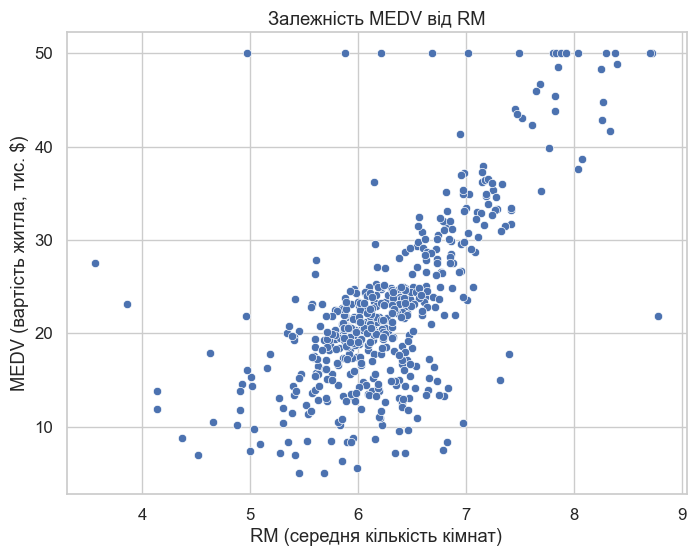

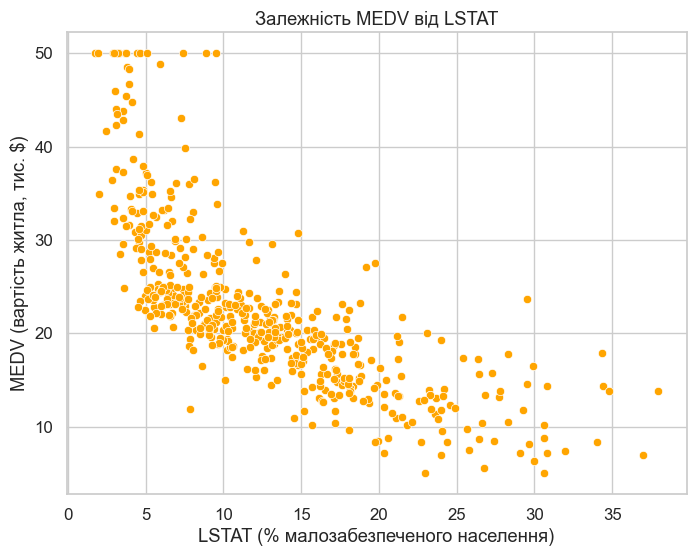

In [4]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["RM"], y=df["MEDV"])
plt.title("Залежність MEDV від RM")
plt.xlabel("RM (середня кількість кімнат)")
plt.ylabel("MEDV (вартість житла, тис. $)")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["LSTAT"], y=df["MEDV"], color="orange")
plt.title("Залежність MEDV від LSTAT")
plt.xlabel("LSTAT (% малозабезпеченого населення)")
plt.ylabel("MEDV (вартість житла, тис. $)")
plt.show()


## 2. Розбиття даних на навчальний, валідаційний та тестовий набори

За умовою:
- навчальний набір (train) — для навчання моделі
- перевірочний (validation) — для налаштування гіперпараметрів
- тестовий (test) — для остаточної оцінки якості моделі.

Використаємо пропорції:
- 60% — train
- 20% — validation
- 20% — test.


In [5]:
# X – всі ознаки, y – цільова змінна MEDV
features_to_drop = ["MEDV"]
if "CAT. MEDV" in df.columns:
    features_to_drop.append("CAT. MEDV")

X = df.drop(features_to_drop, axis=1)
y = df["MEDV"]

# 60% train, 40% тимчасовий набір
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=RANDOM_STATE
)

# 20% validation, 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")


Train size: 303
Validation size: 101
Test size: 102


## 3. Метрики якості та базова модель

У задачі регресії розглянемо такі показники якості:

- **R² (coefficient of determination)** — частка поясненої варіації;
- **RMSE (Root Mean Squared Error)** — корінь із середньоквадратичної помилки;
- **MAPE (Mean Absolute Percentage Error)** — середня відносна помилка.

Для порівняння з ансамблем побудуємо базову індивідуальну модель —
одне дерево рішень `DecisionTreeRegressor`.


In [6]:
def evaluate_reg(model, X_eval, y_eval):
    """Обчислення R2, RMSE та MAPE для регресійної моделі."""
    preds = model.predict(X_eval)
    return {
        "R2": r2_score(y_eval, preds),
        "RMSE": root_mean_squared_error(y_eval, preds),
        "MAPE": mean_absolute_percentage_error(y_eval, preds)
    }

# Базове дерево рішень глибини 3
baseline_model = DecisionTreeRegressor(max_depth=3, random_state=RANDOM_STATE)
baseline_model.fit(X_train, y_train)

baseline_metrics_val = evaluate_reg(baseline_model, X_val, y_val)
baseline_rmse = baseline_metrics_val["RMSE"]
baseline_metrics_val


{'R2': 0.5542098332157297,
 'RMSE': 5.414593254742437,
 'MAPE': 0.18252276566538544}

### Теорія AdaBoostRegressor 
Алгоритм **AdaBoost (Adaptive Boosting)** будує ансамбль з багатьох слабких
моделей (у нашому випадку — дерев рішень). Ідея:

1. Спочатку навчається перше дерево на всіх прикладах.
2. Потім ваги об'єктів змінюються: приклади, які були передбачені неправильно,
   отримують більшу вагу.
3. Наступне дерево більше "уваги" приділяє складним прикладам.
4. Підсумковий прогноз — зважена сума відповідей усіх дерев.

Гіперпараметри:
- `n_estimators` — кількість слабких моделей (дерев);
- `learning_rate` — "швидкість навчання", масштабує внесок кожного дерева;
- `loss` — тип функції втрат (`"linear"`, `"square"`, `"exponential"`).

Мета: підібрати такі параметри, які мінімізують помилку на validation set.


In [7]:
param_n_estimators = [50, 100, 200, 300]
param_learning_rate = [0.01, 0.1, 1.0]
param_loss = ["linear", "square", "exponential"]

ada_results = []

for n in param_n_estimators:
    for lr in param_learning_rate:
        for loss in param_loss:
            model = AdaBoostRegressor(
                n_estimators=n,
                learning_rate=lr,
                loss=loss,
                random_state=RANDOM_STATE
            )
            model.fit(X_train, y_train)
            metrics_val = evaluate_reg(model, X_val, y_val)

            ada_results.append({
                "n_estimators": n,
                "learning_rate": lr,
                "loss": loss,
                **metrics_val
            })

ada_df = pd.DataFrame(ada_results)
ada_df.sort_values("RMSE").head()


,n_estimators,learning_rate,loss,R2,RMSE,MAPE
34,300,1.0,square,0.853579,3.103150,0.124044
25,200,1.0,square,0.851372,3.126441,0.124589
33,300,1.0,linear,0.844751,3.195324,0.125766
16,100,1.0,square,0.844371,3.199235,0.129168
35,300,1.0,exponential,0.843319,3.210029,0.130167


### Аналіз результатів на валідаційній вибірці

За отриманою таблицею `ada_df` обираємо той набір гіперпараметрів,
який дає **мінімальне значення RMSE** (тобто найкращу якість моделі
на validation set).


In [8]:
best_params = ada_df.sort_values("RMSE").iloc[0]
best_params


n_estimators          300
learning_rate         1.0
loss               square
R2               0.853579
RMSE              3.10315
MAPE             0.124044
Name: 34, dtype: object

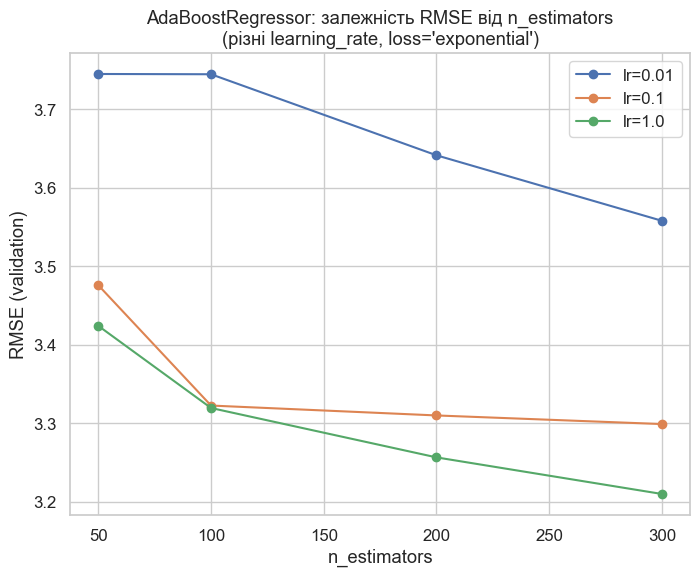

In [9]:
plt.figure(figsize=(8, 6))

for lr in param_learning_rate:
    subset = ada_df[(ada_df["learning_rate"] == lr) & (ada_df["loss"] == "exponential")]
    if subset.empty:
        continue
    plt.plot(
        subset["n_estimators"],
        subset["RMSE"],
        marker="o",
        label=f"lr={lr}"
    )

plt.xlabel("n_estimators")
plt.ylabel("RMSE (validation)")
plt.title("AdaBoostRegressor: залежність RMSE від n_estimators\n(різні learning_rate, loss='exponential')")
plt.legend()
plt.grid(True)
plt.show()


**Інтерпретація графіка:**

- Для малих значень `n_estimators` ансамбль ще недостатньо складний.
- При збільшенні кількості дерев якість покращується до певного оптимуму.
- Далі надмірне збільшення `n_estimators` може призводити до переобучення або
  до насичення (покращення майже немає).
- Параметр `learning_rate` впливає на те, наскільки сильно кожне нове дерево
  коригує підсумковий прогноз: великі значення прискорюють навчання, але
  можуть робити модель менш стабільною.


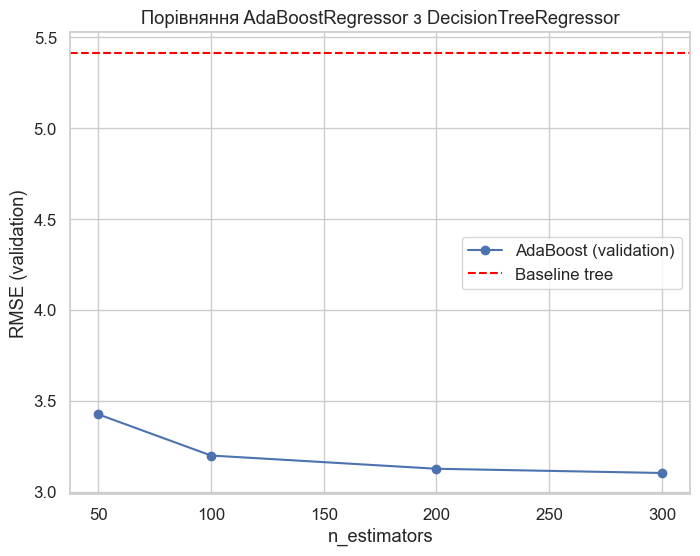

In [10]:
plt.figure(figsize=(8, 6))

# Беремо тільки один тип loss (найкращий), напр. exponential
subset = ada_df[ada_df["loss"] == best_params["loss"]]

plt.plot(
    subset["n_estimators"].unique(),
    subset.groupby("n_estimators")["RMSE"].min(),
    marker="o",
    label="AdaBoost (validation)"
)

# Горизонтальна лінія — базове дерево
plt.axhline(baseline_rmse, color="red", linestyle="--", label="Baseline tree")

plt.xlabel("n_estimators")
plt.ylabel("RMSE (validation)")
plt.title("Порівняння AdaBoostRegressor з DecisionTreeRegressor")
plt.legend()
plt.grid(True)
plt.show()


З графіка видно, що ансамбль AdaBoostRegressor демонструє кращу якість
(нижче значення RMSE), ніж одиничне дерево рішень. Горизонтальна лінія,
що відповідає базовій моделі, знаходиться вище кривої RMSE для AdaBoost.
Це підтверджує перевагу ансамблевого підходу над окремою моделлю.


### Навчання фінальної моделі та оцінка на тестовому наборі

Фінальну модель будуємо з оптимальними параметрами, знайденими за
валідаційною вибіркою. Навчаємо її на об’єднаних даних `train + validation`
та оцінюємо якість на незалежному тестовому наборі `test`.


In [11]:
final_model = AdaBoostRegressor(
    n_estimators=int(best_params["n_estimators"]),
    learning_rate=float(best_params["learning_rate"]),
    loss=best_params["loss"],
    random_state=RANDOM_STATE
)

# Об’єднуємо train + validation
X_final = pd.concat([X_train, X_val])
y_final = pd.concat([y_train, y_val])

final_model.fit(X_final, y_final)

final_metrics_test = evaluate_reg(final_model, X_test, y_test)
final_metrics_test


{'R2': 0.8062249038005284,
 'RMSE': 4.079143059113743,
 'MAPE': 0.17089848762334398}

### Важливість ознак (Feature Importances)

Алгоритм AdaBoostRegressor використовує дерева рішень як базові моделі,
що дозволяє оцінити внесок кожної ознаки у підсумковий прогноз.


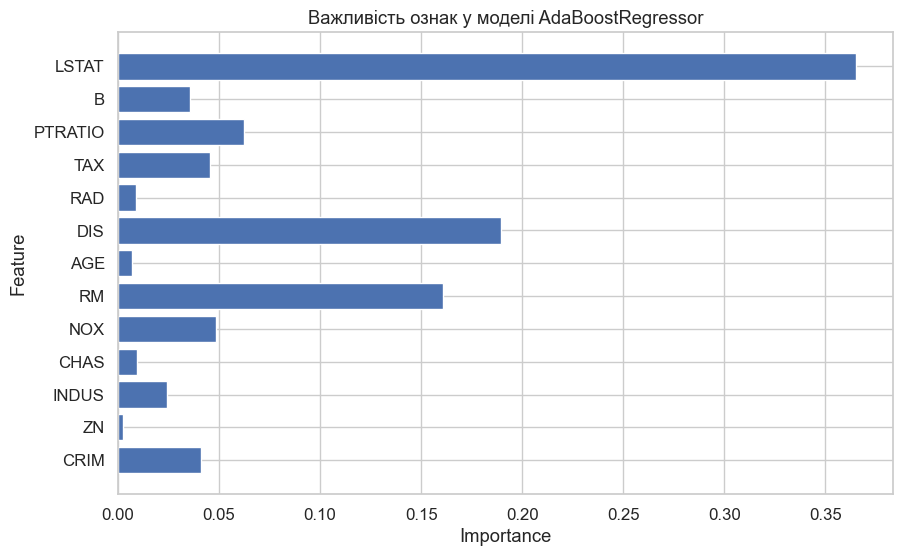

In [12]:
import numpy as np

importances = final_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.title("Важливість ознак у моделі AdaBoostRegressor")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.show()


### Порівняння реальних значень та прогнозів

Для якісної оцінки моделі побудуємо графік:
- по осі X — реальні значення MEDV
- по осі Y — передбачені прогнозом.

Ідеальна модель давала б точки, що лежать на діагональній прямій.


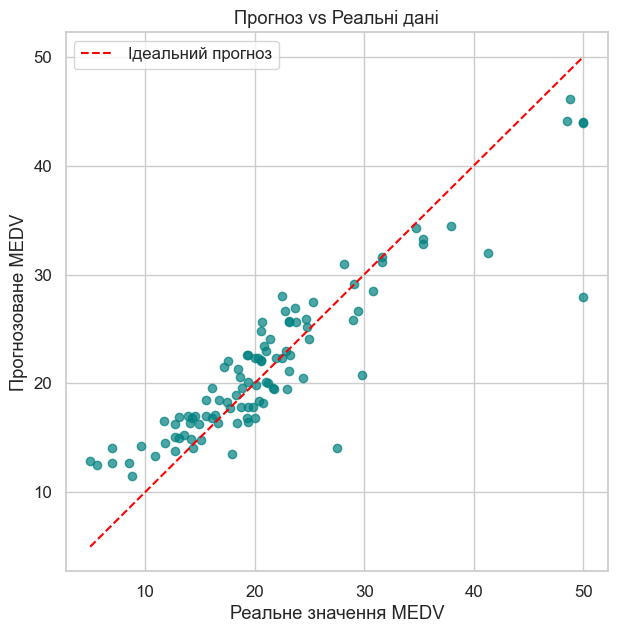

In [13]:
y_pred = final_model.predict(X_test)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.7, color="teal")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color="red", linestyle="--", label="Ідеальний прогноз")

plt.xlabel("Реальне значення MEDV")
plt.ylabel("Прогнозоване MEDV")
plt.title("Прогноз vs Реальні дані")
plt.legend()
plt.grid(True)
plt.show()


### Розподіл помилок (Error Distribution)

Перевіримо, як модель помиляється:  
побудуємо гістограму помилок `error = y_test − y_pred`.


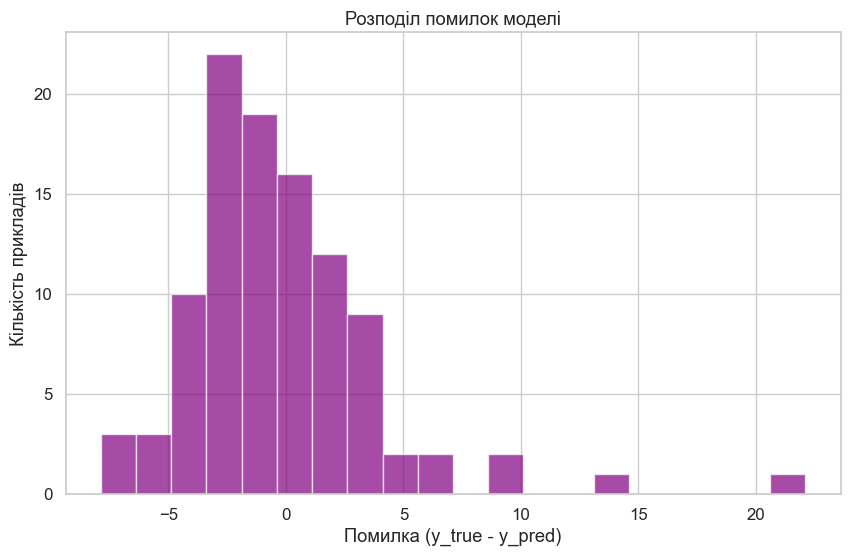

In [14]:
errors = y_test - y_pred

plt.figure(figsize=(10,6))
plt.hist(errors, bins=20, color="purple", alpha=0.7)
plt.title("Розподіл помилок моделі")
plt.xlabel("Помилка (y_true - y_pred)")
plt.ylabel("Кількість прикладів")
plt.grid(True)
plt.show()


### Кореляційна матриця

Для аналізу взаємозв’язків між ознаками побудуємо heatmap кореляцій.


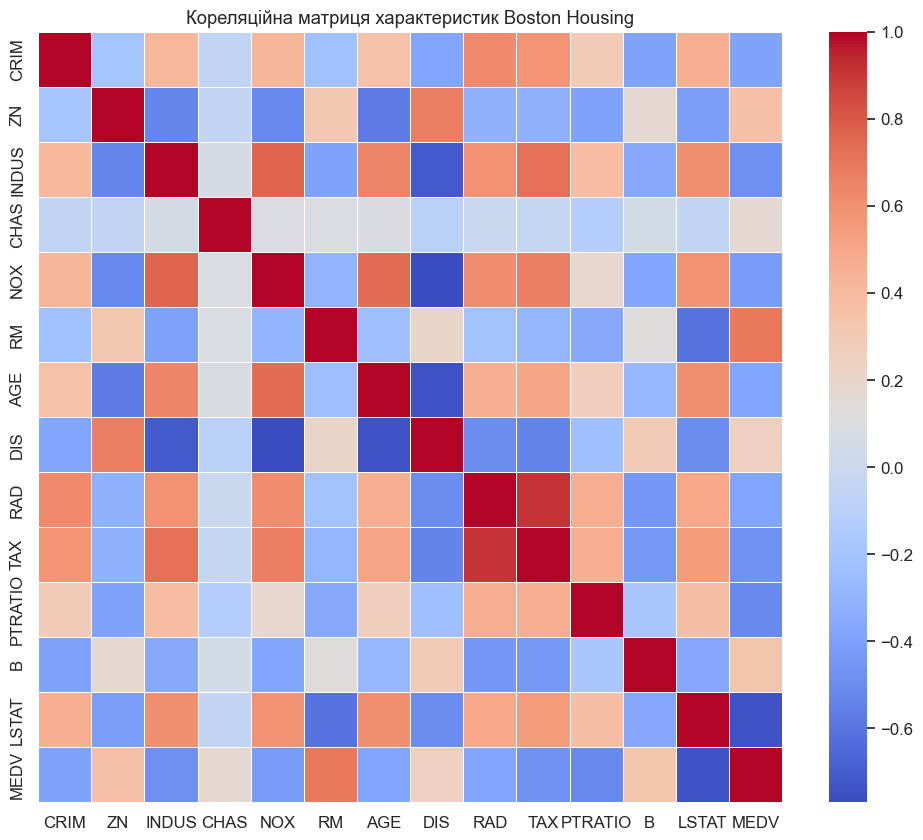

In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Кореляційна матриця характеристик Boston Housing")
plt.show()


### Інтерпретація додаткових графіків

1. **Важливість ознак** показує, що моделі найбільше впливають такі фактори, як:
   - RM (кількість кімнат)
   - LSTAT (рівень малозабезпеченості)
   - NOX (забруднення повітря)
2. **Scatter-графік прогнозів** показує хорошу узгодженість між реальними
   та передбаченими значеннями (більшість точок поблизу діагоналі).
3. **Розподіл помилок** демонструє приблизно симетричний розподіл навколо 0,
   що є ознакою хорошої моделі.
4. **Кореляційна матриця** підтверджує сильні зв’язки:
   - RM ↗ MEDV
   - LSTAT ↘ MEDV
   - TAX ↘ MEDV



## 4. Порівняння прогнозів ансамблю AdaBoost та базового дерева

Для наочного порівняння результатів окремої моделі і ансамблю побудуємо графіки прогнозної поверхні на площині двох ознак (RM та LSTAT). Щоб спростити візуалізацію, навчимо моделі тільки на цих двох ознаках і подивимось, як вони апроксимують цільову функцію.

На цьому етапі порівняємо **форму прогнозів** двох моделей:

- базове дерево рішень глибиною 3 (`DecisionTreeRegressor`);
- ансамбль `AdaBoostRegressor` з найкращими гіперпараметрами `best_params`.

Для візуалізації візьмемо дві найінформативніші ознаки, які вже
використовувались раніше: **RM** (середня кількість кімнат) та **LSTAT**
(відсоток населення з низьким соціально-економічним статусом). На площині
RM–LSTAT побудуємо:

1. **поверхню прогнозу ансамблю** (колірний фон);
2. **ізолінії прогнозу окремого дерева**;
3. **реальні тестові об’єкти** як точки.

Ансамбль AdaBoost має давати більш плавну,
нелінійну поверхню, тоді як окреме дерево формує грубі «сходинки» через
розбиття простору ознак на прямокутні області.


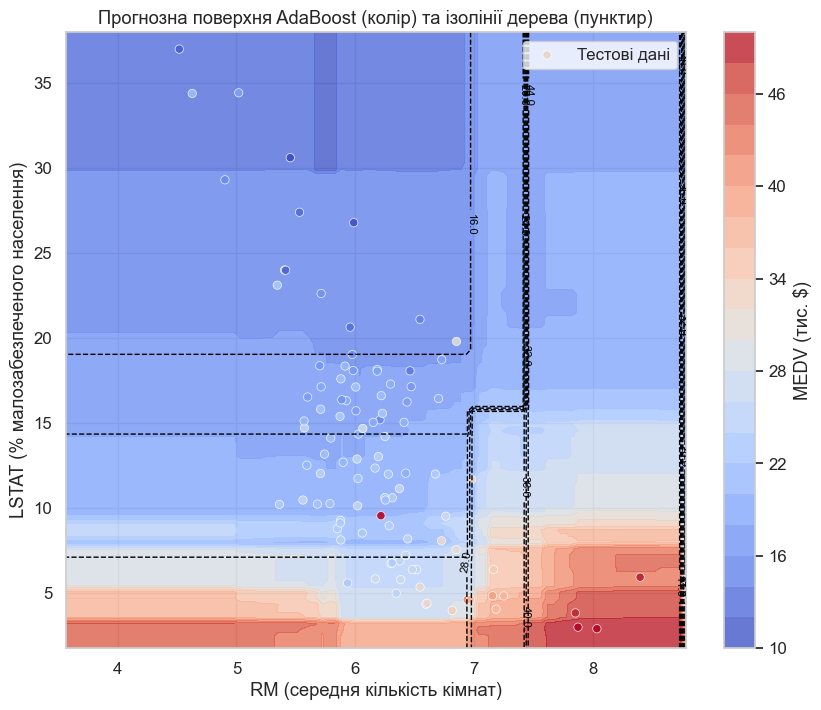

In [16]:

# 2D-підпростір за ознаками RM та LSTAT
features_2d = ["RM", "LSTAT"]

# Перевіряємо, що потрібні ознаки є в датасеті
missing = [f for f in features_2d if f not in X.columns]
if missing:
    raise ValueError(f"У датасеті відсутні ознаки: {missing}")

X_train_2d = X_train[features_2d]
X_test_2d = X_test[features_2d]

# Базове дерево та ансамбль з найкращими параметрами
tree_2d = DecisionTreeRegressor(max_depth=3, random_state=RANDOM_STATE)
tree_2d.fit(X_train_2d, y_train)

ada_2d = AdaBoostRegressor(
    n_estimators=int(best_params["n_estimators"]),
    learning_rate=float(best_params["learning_rate"]),
    loss=best_params["loss"],
    random_state=RANDOM_STATE
)
ada_2d.fit(X_train_2d, y_train)

# Створюємо сітку значень RM та LSTAT
rm_grid = np.linspace(df["RM"].min(), df["RM"].max(), 100)
lstat_grid = np.linspace(df["LSTAT"].min(), df["LSTAT"].max(), 100)
RM_grid, LSTAT_grid = np.meshgrid(rm_grid, lstat_grid)

grid_df = pd.DataFrame({
    "RM": RM_grid.ravel(),
    "LSTAT": LSTAT_grid.ravel()
})

# Прогнози на сітці
ada_pred_grid = ada_2d.predict(grid_df).reshape(RM_grid.shape)
tree_pred_grid = tree_2d.predict(grid_df).reshape(RM_grid.shape)

# Візуалізація
plt.figure(figsize=(10, 8))

# Поверхня ансамблю
cont = plt.contourf(
    RM_grid, LSTAT_grid, ada_pred_grid,
    levels=20, cmap="coolwarm", alpha=0.8
)

# Ізолінії базового дерева
cs = plt.contour(
    RM_grid, LSTAT_grid, tree_pred_grid,
    levels=10, colors="black", linestyles="dashed", linewidths=1
)
plt.clabel(cs, inline=True, fontsize=8, fmt="%.1f")

# Тестові точки
sc = plt.scatter(
    X_test_2d["RM"], X_test_2d["LSTAT"],
    c=y_test, cmap="coolwarm", edgecolor="white", linewidth=0.5,
    alpha=0.9, label="Тестові дані"
)

plt.xlabel("RM (середня кількість кімнат)")
plt.ylabel("LSTAT (% малозабезпеченого населення)")
plt.title("Прогнозна поверхня AdaBoost (колір) та ізолінії дерева (пунктир)")
plt.colorbar(cont, label="MEDV (тис. $)")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()



### Висновки до завдання 4

Вище наведено графік, де фон зафарбовано за значеннями прогнозу ансамблю AdaBoost (колірна карта coolwarm: синій – нижча ціна, червоний – вища). Пунктирними лініями показані лінії-рівні прогнозу окремого дерева  – вони ілюструють, які значення цін передбачає базове дерево в різних областях простору ознак.
Як видно ансамбль AdaBoost моделює більш гладку, нелінійну поверхню залежності ціни від RM та LSTAT (колірний фон змінюється поступово). Окреме дерево глибиною 3 формує значно грубіший наближений розв’язок – ізолінії цін мають форму прямокутних областей, що відповідає сегментації простору ознак на великі регіони із постійним прогнозом. Наприклад, дерево може передбачати фіксовану ціну для всіх районів з LSTAT вище певного порогу і RM вище певного порогу, що дає різку границю на графіку (пунктирна лінія). AdaBoost, комбінуючи багато дерев, інтерполює більш плавно між цими регіонами. Його прогнозна поверхня ближче повторює реальний континуум цін: в області високого RM та низького LSTAT ансамбль прогнозує найвищі ціни (червона зона), тоді як базове дерево там також дає високі значення, але менш точно окреслює межі зони. В області низького RM та високого LSTAT (нижній правий кут) обидві моделі прогнозують низькі ціни (синя зона). Помітно, що ансамбль має менше різких стрибків і адаптується до нюансів – наприклад, на кольоровій карті є плавний перехід від синього до зеленуватого при збільшенні RM навіть за високого LSTAT, тоді як дерево тримає ціну постійною до певного порогу RM. Отже, ансамбль краще моделює складні взаємозв'язки ознак, тоді як окреме дерево грубіше наближає залежність.

- **Ансамбль AdaBoost** формує більш гладку, безперервну поверхню: перехід
  від низьких до високих цін відбувається поступово при зміні RM та LSTAT.
- **Базове дерево** ділить простір на великі прямокутні блоки з постійним
  прогнозом, тому його ізолінії мають «східчасту» форму.
- В області *високого RM* і *низького LSTAT* ансамбль точніше окреслює
  зону дорогого житла, тоді як дерево дає грубіші межі.
- В області *низького RM* та *високого LSTAT* обидві моделі прогнозують
  низькі ціни, але ансамбль краще відтворює плавний перехід усередині цієї
  області.

Така комбінація багатьох дерев дає
можливість ансамблю наблизити складну поверхню залежності ціни від ознак,
тоді як одне дерево обмежене жорсткими прямокутними областями.



## 5. Оцінка зміщення та дисперсії моделі

Щоб зрозуміти, **чому ансамбль працює краще, ніж окреме дерево**, розкладемо
помилку на дві складові:

- **зміщення (bias²)** — наскільки середній прогноз моделі відхиляється
  від справжніх значень;
- **дисперсія (variance)** — наскільки сильно змінюються прогнози моделі
  при зміні навчальної вибірки.

Використаємо бутстреп-підхід: багато разів вибираємо навчальну вибірку з
поверненням, навчаємо на ній дерево й ансамбль, отримуємо прогнози на
фіксованому тестовому наборі та обчислюємо середні оцінки bias², variance
та загальної MSE.


In [17]:

from sklearn.utils import resample

def estimate_bias_variance(model_factory, X_train, y_train, X_test, y_test,
                           n_runs=30, random_state=42):
    """Оцінка bias², variance та MSE для моделі за допомогою бутстрепу."""
    rng = np.random.RandomState(random_state)
    all_preds = []

    for i in range(n_runs):
        # Бутстреп-вибірка з навчальних даних
        X_boot, y_boot = resample(X_train, y_train,
                                  random_state=rng.randint(0, 1_000_000))
        model = model_factory()
        model.fit(X_boot, y_boot)
        all_preds.append(model.predict(X_test))

    all_preds = np.vstack(all_preds)          # shape: (n_runs, n_test)
    mean_preds = all_preds.mean(axis=0)       # середній прогноз
    y_true = y_test.values

    bias2 = np.mean((mean_preds - y_true) ** 2)
    variance = np.mean(all_preds.var(axis=0))
    mse = np.mean((all_preds - y_true) ** 2)

    return {
        "bias2": bias2,
        "variance": variance,
        "mse": mse
    }

# Фабрики моделей
def make_tree():
    return DecisionTreeRegressor(max_depth=3, random_state=RANDOM_STATE)

def make_ada():
    return AdaBoostRegressor(
        n_estimators=int(best_params["n_estimators"]),
        learning_rate=float(best_params["learning_rate"]),
        loss=best_params["loss"],
        random_state=RANDOM_STATE
    )

tree_stats = estimate_bias_variance(make_tree, X_train, y_train, X_test, y_test)
ada_stats = estimate_bias_variance(make_ada, X_train, y_train, X_test, y_test)

pd.DataFrame([tree_stats, ada_stats], index=["Decision Tree", "AdaBoost"])


,bias2,variance,mse
Decision Tree,15.878698,8.488519,24.367218
AdaBoost,15.287415,2.601255,17.888670


### Висновки до завдання 5

Як бачимо, ансамбль має менше як зміщення, так і дисперсію порівняно з окремим деревом. В нашому випадку базове дерево досить просте, тому воно недоадаптується до навчальних даних, що дає значне зміщення (MSE відстань між середнім прогнозом моделі та реальними значеннями). Одночасно різні варіанти дерева дають досить різні результати для одних і тих самих об’єктів, що відображається в помітній дисперсії AdaBoost, навпаки, суттєво знижує дисперсію моделі – його прогнози набагато стабільніші при варіюванні навчальних даних. Це очікувано, адже ансамбль усереднює багато моделей, згладжуючи випадкові коливання окремих дерев. Цікаво, що зміщення ансамблю також трохи зменшилося, тобто бустинг покращив відповідність середнього прогнозу реальним значенням. Зниження зміщення – це результат підвищення складності моделі: комбінуючи багато дерев, ансамбль може вловити більш складні залежності (менша систематична помилка). Отже, загальна середньоквадратична помилка менша, ніж для одного дерева, що узгоджується з раніше отриманими метриками якості. Таким чином, AdaBoostRegressor досягає кращого балансу bias-variance, що приводить до вищої точності.

- **Ансамбль AdaBoost** має:
  - дещо менше **зміщення (bias²)**, ніж окреме дерево;
  - суттєво меншу **дисперсію**, тобто його прогнози стійкіші до зміни
    навчальної вибірки;
  - відповідно менший **MSE** як суму bias² + variance.
